# Topology of Transformer Models
## Persistent Homology of Attention Heads

We compute the distance between two heads as, 

\begin{equation}
D(H_i, H_j) = \sum_{\text{token} \in \text{input\_data}} JS(H_i(token), H_j(token))
\end{equation}

where $JS$ denotes the Jensen-Shannon divergence. To ensure that the given function is a true distance metric, we need to modify it to satisfy the properties of a distance metric. A distance metric must satisfy the following conditions:

1. Non-negativity: $D(H_i, H_j) \geq 0$
2. Identity of indiscernibles: $D(H_i, H_j) = 0$ if and only if $H_i = H_j$
3. Symmetry: $D(H_i, H_j) = D(H_j, H_i)$
4. Triangle inequality: $D(H_i, H_j) + D(H_j, H_k) \geq D(H_i, H_k)$

Since the Jensen-Shannon divergence is already non-negative, symmetric, and always zero when comparing identical distributions, the only property we need to address is the triangle inequality. Note, we create a genuine distance metric in order to perform a persistent homology analysis, which requires a distance metric. We can achieve this by using the square root of Jensen-Shannon divergence as our distance metric, which is known as Jensen-Shannon distance (JSD). The modified distance metric would then be:

\begin{equation}
D(H_i, H_j) = \sum_{\text{token} \in \text{input\_data}} \sqrt{ JS(H_i(\text{token}), H_j(\text{token}))}.
\end{equation}

Now, the given function should satisfy all the properties of a true distance metric. Once we have this distance matrix in hand, giving the distances between each pair of heads in the model, we can compute the persistent homology and plot the barcode diagram. We do this for Bert, then GPT-2 individually. Then we do this for both at the same time and compute the bottleneck distance between their barcode diagrams. This is based on the analysis in $\S 6$ on "Clustering Attention Heads" of the article [What Does BERT Look At? An Analysis of BERT’s Attention](https://arxiv.org/abs/1906.04341). In this article the question of "Are attention heads in the same layer similar to each other or different? Can attention heads be clearly grouped by behavior? We investigate these
questions by computing the distances between all pairs of attention heads." 

It is stated there, "We find that there are several clear clusters of heads that be have similarly, often corresponding to behaviors we have already discussed in this paper. Heads within the same layer are often fairly close to each other, meaning that heads within the layer have similar attention distributions. This finding is a bit surprising given that [Multi-Head Attention with Disagreement Regularization](https://arxiv.org/abs/1810.10183) shows that encouraging attention heads to have different behaviors can improve Transformer performance at machine translation. One possibility for the apparent redundancy in BERT’s attention heads is the use of attention dropout, which causes some attention weights to be zeroed-out during training." From this, we may gather that persistent topological features are in fact detrimental to the performance of the model. In which case we should discourage them during training. In other words, the information theoretic Jensen-Shannon distance should be encouraged to be largers between specific attention heads that form clusters or higher dimensional topological featurs. 

The bottleneck distance from persistent homology allows us to tell the model to increase the pairwise distances $D(H_i, H_j)$ without specifying how to change each $\sqrt{ JS(H_i(\text{token}), H_j(\text{token}))}$, meaning there is flexibility in how the individual attention weights of a single head might be distributed, so long as the overall pairwise distances $D(H_i, H_j)$ are increased. By promoting larger Jensen-Shannon distances between specific attention heads that form clusters or higher-dimensional topological features, we enable the model to increase pairwise distances $D(H_i, H_j)$ without dictating the distribution of individual attention weights of a single head, thereby retaining flexibility in the distribution of attention weights while enhancing overall performance. It is important to note that this is an alternated way on encouraging the model to had heads behave differently than the three methods presented in [Multi-Head Attention with Disagreement Regularization](https://arxiv.org/abs/1810.10183). 

In [1]:
pip install numpy torch transformers gudhi networkx scipy plotly ipywidgets -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import jensenshannon

# Load the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

# Prepare the input data
input_text = "Quantum information theory is interesting."
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Get the attention matrices
with torch.no_grad():
    outputs = model(input_ids)
    attentions = outputs[-1]

# Calculate the pairwise Jensen-Shannon distance
num_layers = len(attentions)
num_heads = attentions[0].shape[1]

distances = torch.zeros((num_layers, num_heads, num_heads))

for layer_idx, layer_attentions in enumerate(attentions):
    for head_i in range(num_heads):
        for head_j in range(head_i, num_heads):
            tokens_js_distances = [
                jensenshannon(
                    layer_attentions[0, head_i, token].numpy(),
                    layer_attentions[0, head_j, token].numpy(),
                )
                for token in range(input_ids.shape[1])
            ]
            distance = sum(tokens_js_distances)
            distances[layer_idx, head_i, head_j] = distance
            distances[layer_idx, head_j, head_i] = distance

# Print the distance matrix
print(distances)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[[0.0000, 2.9036, 3.6939,  ..., 2.7101, 3.9613, 3.3373],
         [2.9036, 0.0000, 3.8505,  ..., 3.3878, 3.8944, 3.2137],
         [3.6939, 3.8505, 0.0000,  ..., 3.7885, 4.1424, 3.4333],
         ...,
         [2.7101, 3.3878, 3.7885,  ..., 0.0000, 4.4913, 2.8837],
         [3.9613, 3.8944, 4.1424,  ..., 4.4913, 0.0000, 3.1264],
         [3.3373, 3.2137, 3.4333,  ..., 2.8837, 3.1264, 0.0000]],

        [[0.0000, 2.8963, 2.6987,  ..., 2.4124, 2.9581, 2.8915],
         [2.8963, 0.0000, 2.9051,  ..., 3.3288, 2.9527, 3.5461],
         [2.6987, 2.9051, 0.0000,  ..., 2.6115, 2.0569, 3.4727],
         ...,
         [2.4124, 3.3288, 2.6115,  ..., 0.0000, 2.7227, 2.8624],
         [2.9581, 2.9527, 2.0569,  ..., 2.7227, 0.0000, 3.1597],
         [2.8915, 3.5461, 3.4727,  ..., 2.8624, 3.1597, 0.0000]],

        [[0.0000, 4.6471, 4.8262,  ..., 0.3603, 5.0283, 4.6528],
         [4.6471, 0.0000, 1.8615,  ..., 4.5179, 2.3104, 2.5003],
         [4.8262, 1.8615, 0.0000,  ..., 4.7978, 2.2949, 2.

<Figure size 640x480 with 0 Axes>

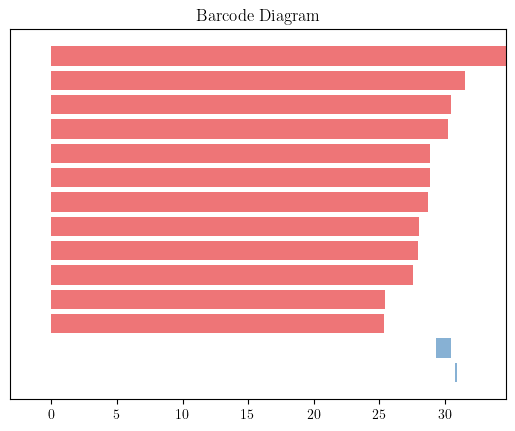

In [11]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt

# Flatten the distance tensor to 2D (summing across all layers)
flat_distances = distances.sum(dim=0).numpy()

# Compute the Rips complex
rips_complex = gd.RipsComplex(distance_matrix=flat_distances, max_edge_length=np.inf)

# Compute the simplex tree
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# Compute the persistence diagram
persistence_diagram = simplex_tree.persistence()

# Plot the barcode diagram
plt.figure()
gd.plot_persistence_barcode(persistence=persistence_diagram)
plt.title("Barcode Diagram")
plt.show()


In [12]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
from scipy.spatial.distance import jensenshannon

# Load the GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_attentions=True)

# Prepare the input data
input_text = "Quantum information theory is interesting."
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Get the attention matrices
with torch.no_grad():
    outputs = model(input_ids)
    attentions = outputs[-1]

# Calculate the pairwise Jensen-Shannon divergence
num_layers = len(attentions)
num_heads = attentions[0].shape[1]

distances = torch.zeros((num_layers, num_heads, num_heads))

for layer_idx, layer_attentions in enumerate(attentions):
    for head_i in range(num_heads):
        for head_j in range(head_i, num_heads):
            tokens_js_divergences = [
                jensenshannon(
                    layer_attentions[0, head_i, token].numpy(),
                    layer_attentions[0, head_j, token].numpy(),
                )
                for token in range(input_ids.shape[1])
            ]
            distance = sum(tokens_js_divergences)
            distances[layer_idx, head_i, head_j] = distance
            distances[layer_idx, head_j, head_i] = distance

# Print the distance matrix
print(distances)


tensor([[[0.0000, 4.5110, 1.1804,  ..., 1.2408, 1.7750, 1.1544],
         [4.5110, 0.0000, 4.0747,  ..., 4.0066, 3.2373, 3.9290],
         [1.1804, 4.0747, 0.0000,  ..., 0.4985, 1.2266, 1.0105],
         ...,
         [1.2408, 4.0066, 0.4985,  ..., 0.0000, 1.0513, 1.0436],
         [1.7750, 3.2373, 1.2266,  ..., 1.0513, 0.0000, 1.1241],
         [1.1544, 3.9290, 1.0105,  ..., 1.0436, 1.1241, 0.0000]],

        [[0.0000, 1.0196, 0.9089,  ..., 1.4444, 3.0945, 2.7294],
         [1.0196, 0.0000, 0.5684,  ..., 0.9232, 3.1902, 2.6768],
         [0.9089, 0.5684, 0.0000,  ..., 1.0421, 3.1594, 2.6112],
         ...,
         [1.4444, 0.9232, 1.0421,  ..., 0.0000, 3.6793, 3.0656],
         [3.0945, 3.1902, 3.1594,  ..., 3.6793, 0.0000, 2.8364],
         [2.7294, 2.6768, 2.6112,  ..., 3.0656, 2.8364, 0.0000]],

        [[0.0000, 1.0576, 1.7275,  ..., 1.8072, 1.2734, 0.8740],
         [1.0576, 0.0000, 2.3138,  ..., 2.4735, 1.8560, 0.8292],
         [1.7275, 2.3138, 0.0000,  ..., 1.5069, 1.5614, 1.

<Figure size 640x480 with 0 Axes>

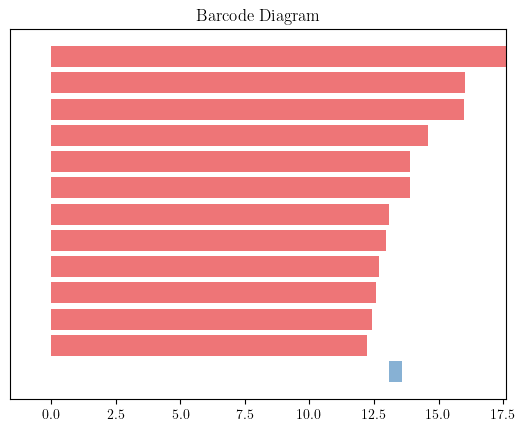

In [13]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt

# Flatten the distance tensor to 2D (summing across all layers)
flat_distances = distances.sum(dim=0).numpy()

# Compute the Rips complex
rips_complex = gd.RipsComplex(distance_matrix=flat_distances, max_edge_length=np.inf)

# Compute the simplex tree
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# Compute the persistence diagram
persistence_diagram = simplex_tree.persistence()

# Plot the barcode diagram
plt.figure()
gd.plot_persistence_barcode(persistence=persistence_diagram)
plt.title("Barcode Diagram")
plt.show()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(value='Quantum information theory is interesting and can provide insights into other areas of research', …

Button(description='Submit', style=ButtonStyle())

<Figure size 640x480 with 0 Axes>

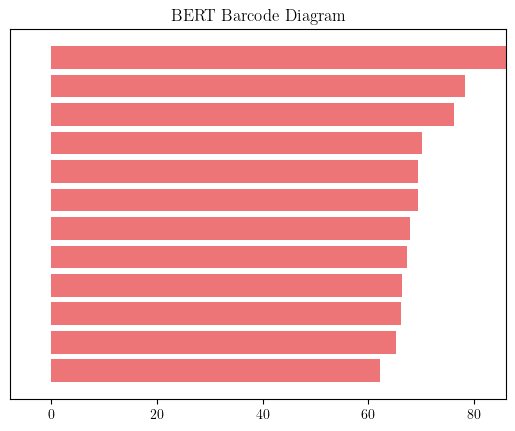

<Figure size 640x480 with 0 Axes>

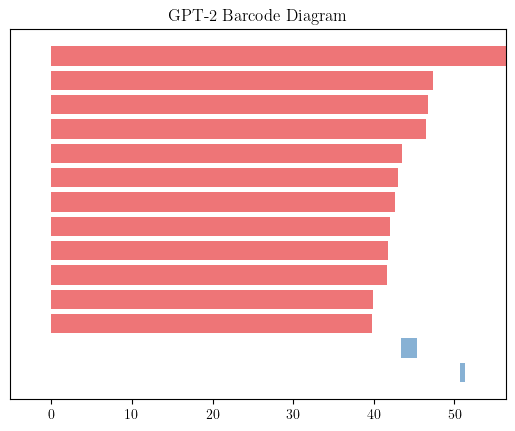

Bottleneck distance: 30.976749420166016


In [ ]:
import torch
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
from scipy.spatial.distance import jensenshannon
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets

def get_js_distance_matrix(model, tokenizer, input_text):
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(input_ids)
        attentions = outputs[-1]

    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]
    distances = torch.zeros((num_layers, num_heads, num_heads))

    for layer_idx, layer_attentions in enumerate(attentions):
        for head_i in range(num_heads):
            for head_j in range(head_i, num_heads):
                tokens_js_divergences = [
                    jensenshannon(
                        layer_attentions[0, head_i, token].numpy(),
                        layer_attentions[0, head_j, token].numpy(),
                    )
                    for token in range(input_ids.shape[1])
                ]
                distance = sum(tokens_js_divergences)
                distances[layer_idx, head_i, head_j] = distance
                distances[layer_idx, head_j, head_i] = distance

    return distances

def convert_diagram_to_numpy_array(diagram):
    diagram_np = []
    for point in diagram:
        if point[1][1] == float('inf'):
            continue
        diagram_np.append([point[1][0], point[1][1]])
    return np.array(diagram_np)

def plot_barcode_and_bottleneck(pd1, pd2):
    plt.figure()
    gd.plot_persistence_barcode(persistence=pd1)
    plt.title("BERT Barcode Diagram")
    plt.show()

    plt.figure()
    gd.plot_persistence_barcode(persistence=pd2)
    plt.title("GPT-2 Barcode Diagram")
    plt.show()

    # Convert diagrams to NumPy arrays
    pd1_np = convert_diagram_to_numpy_array(pd1)
    pd2_np = convert_diagram_to_numpy_array(pd2)

    # Calculate bottleneck distance
    bottleneck_distance = gd.bottleneck_distance(pd1_np, pd2_np)
    print(f"Bottleneck distance: {bottleneck_distance}")

def on_submit_button_clicked(button):
    input_text = input_text_widget.value

    bert_distances = get_js_distance_matrix(bert_model, bert_tokenizer, input_text)
    gpt2_distances = get_js_distance_matrix(gpt2_model, gpt2_tokenizer, input_text)

    bert_flat_distances = bert_distances.sum(dim=0).numpy()
    gpt2_flat_distances = gpt2_distances.sum(dim=0).numpy()

    bert_rips_complex = gd.RipsComplex(distance_matrix=bert_flat_distances, max_edge_length=np.inf)
    gpt2_rips_complex = gd.RipsComplex(distance_matrix=gpt2_flat_distances, max_edge_length=np.inf)

    bert_simplex_tree = bert_rips_complex.create_simplex_tree(max_dimension=2)
    gpt2_simplex_tree = gpt2_rips_complex.create_simplex_tree(max_dimension=2)

    bert_persistence_diagram = bert_simplex_tree.persistence()
    gpt2_persistence_diagram = gpt2_simplex_tree.persistence()

    plot_barcode_and_bottleneck(bert_persistence_diagram, gpt2_persistence_diagram)

# Load the models and tokenizers
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2Model.from_pretrained("gpt2", output_attentions=True)

# Create the input text widget and submit button
input_text_widget = widgets.Text(
    value="Quantum information theory is interesting and can provide insights into other areas of research",
    placeholder="Enter some text...",
    description="Input Text:",
    disabled=False,
)

submit_button = widgets.Button(description="Submit")
submit_button.on_click(on_submit_button_clicked)

# Display the input text widget and submit button
display(input_text_widget)
display(submit_button)
